In [2]:
import pandas as pd
import numpy as np
import os, re
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
import survivors.datasets as ds
import survivors.constants as cnt

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


### Структура

Вариант 1: стратифицированные модели

Вариант 2: стратифицированные модели только на категориальных

Вариант 3: стратифицированные и стекинговые модели

Результаты:
1. Таблица средних по разной глубине и сравнение с деревом и базовой моделью (3 набора)
2. График зависимости качества от глубины (разные методы на одном графике) 

Выводы:
1. Обработка категориальных без расслоения
2. Обработка пропусков (умное заполнение)
3. Излишняя глубина приводит к проблемам со сходимостью и схожести выборок
4. Лучшее качество на глубине 2-4

In [3]:
glob_dir = os.path.join(os.path.split(os.path.split(os.getcwd())[0])[0], "experiment_results", "Backblaze")

In [260]:
import matplotlib as mpl
mpl.rc('font',family='Times New Roman',size=16)

# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2}, font_scale = 10)

========== backblaze16_18 ==========


C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yti

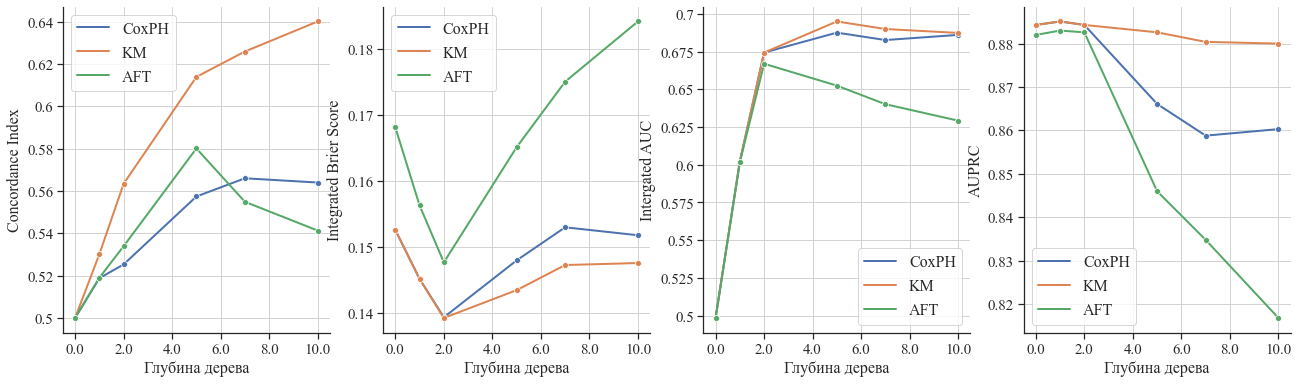

   METHOD        CI IBS_REMAIN IAUC_WW_TI     AUPRC depth
0   CoxPH       0.5     0.1526     0.4985  *0.8843*     0
1   CoxPH    0.5188     0.1452     0.6021  *0.8851*     1
2   CoxPH     0.564     0.1518      0.686    0.8603  *10*
3   CoxPH    0.5253   *0.1394*     0.6743    0.8843     2
4   CoxPH    0.5574      0.148   *0.6875*    0.8661     5
5   CoxPH     0.566      0.153     0.6826    0.8588     7
6    *KM*       0.5     0.1526     0.4985    0.8843     0
7      KM    0.5301     0.1452     0.6021  *0.8851*     1
8    *KM*  *0.6401*     0.1476     0.6873      0.88  *10*
9      KM    0.5634   *0.1393*     0.6743    0.8843     2
10     KM  *0.6139*   *0.1435*   *0.6949*    0.8826     5
11   *KM*  *0.6259*     0.1473   *0.6899*    0.8804     7
24    AFT       0.5     0.1681     0.4985     0.882     0
25    AFT     0.519     0.1563     0.6016     0.883     1
26    AFT    0.5413     0.1841     0.6292    0.8168  *10*
27    AFT    0.5339     0.1477     0.6669    0.8826     2
28    AFT    0

C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yti

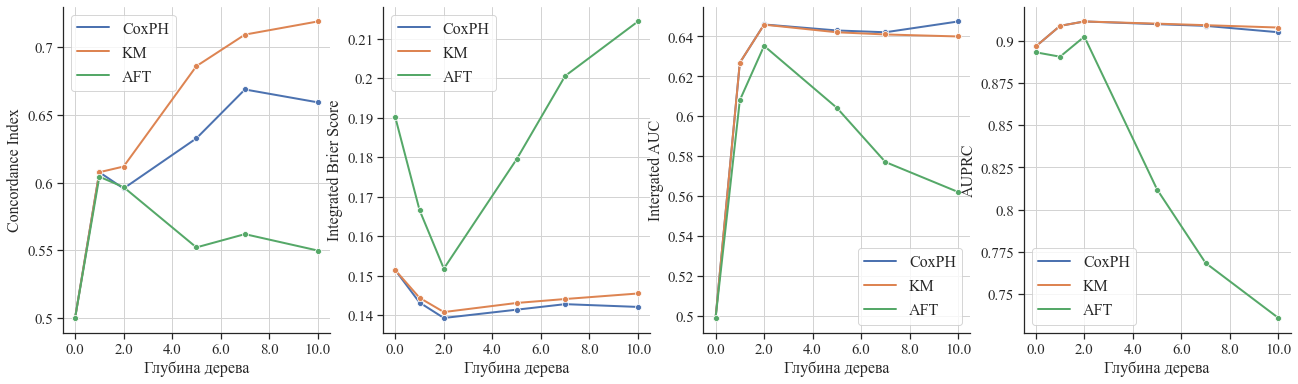

   METHOD        CI IBS_REMAIN IAUC_WW_TI     AUPRC depth
0   CoxPH       0.5     0.1514     0.4992    0.8968     0
1   CoxPH    0.6076     0.1432     0.6268     0.909     1
2   CoxPH    0.6592     0.1421   *0.6475*    0.9052  *10*
3   CoxPH    0.5956   *0.1393*    *0.646*  *0.9116*     2
4   CoxPH    0.6326   *0.1414*      0.643      0.91     5
5   CoxPH    0.6687     0.1428     0.6421     0.909     7
6    *KM*       0.5     0.1514     0.4992    0.8968     0
7      KM    0.6076     0.1444     0.6269     0.909     1
8    *KM*  *0.7189*     0.1455       0.64     0.908  *10*
9      KM    0.6118   *0.1408*   *0.6459*  *0.9116*     2
10     KM  *0.6859*     0.1431     0.6421  *0.9103*     5
11   *KM*  *0.7092*     0.1441      0.641    0.9094     7
24    AFT       0.5     0.1901     0.4992    0.8933     0
25    AFT    0.6043     0.1666     0.6081    0.8907     1
26    AFT    0.5498     0.2144     0.5622    0.7357  *10*
27    AFT    0.5966     0.1518     0.6353    0.9026     2
28    AFT    0

C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_4516\4185843983.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yti

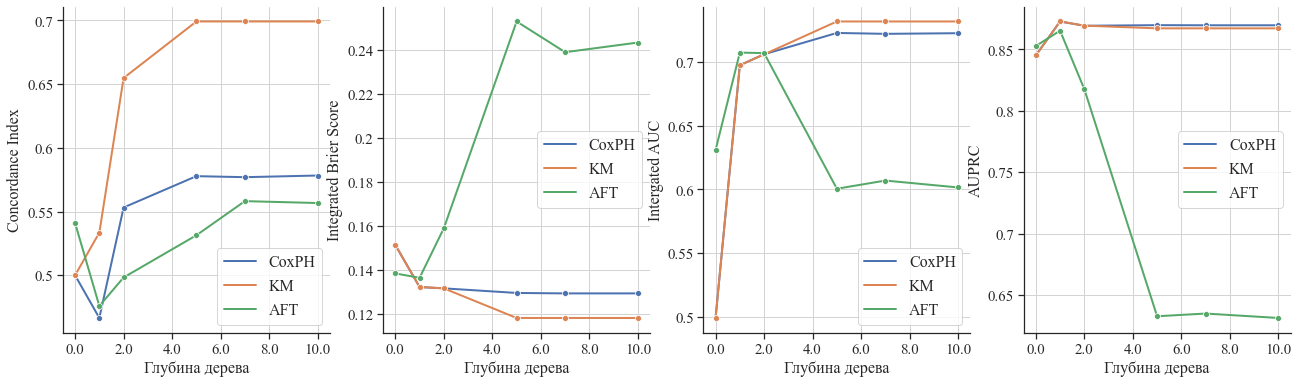

   METHOD        CI IBS_REMAIN IAUC_WW_TI     AUPRC depth
0   CoxPH       0.5     0.1514     0.4993    0.8452     0
1   CoxPH    0.4665     0.1322     0.6974  *0.8728*     1
2   CoxPH    0.5783     0.1293     0.7225    0.8697  *10*
3   CoxPH    0.5532     0.1316      0.706    0.8693     2
4   CoxPH    0.5778     0.1295     0.7227  *0.8698*     5
5   CoxPH     0.577     0.1293      0.722    0.8697     7
6    *KM*       0.5     0.1513     0.4993    0.8452     0
7      KM    0.5335     0.1322     0.6974  *0.8728*     1
8    *KM*  *0.6992*   *0.1181*   *0.7317*    0.8672  *10*
9      KM    0.6548     0.1316     0.7059    0.8694     2
10     KM  *0.6992*   *0.1181*   *0.7317*    0.8672     5
11   *KM*  *0.6992*   *0.1181*   *0.7317*    0.8672     7
24    AFT     0.541     0.1384     0.6309    0.8528     0
25    AFT    0.4759     0.1364     0.7073    0.8653     1
26    AFT    0.5567     0.2436     0.6016    0.6315  *10*
27    AFT    0.4983      0.159     0.7069    0.8177     2
28    AFT    0

In [268]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM",
    "BaseLeafModeLL": "KM",
    "deepsurvCRAID": "DeepSurv",
    "coxtimeCRAID": "CoxTime"}

BASE_MODELS = ["KM", "CoxPH", "WeibullAFT"]

STAT_m = ['BaseLeafModeLL']
ML_m = ["CoxPH", 'ST']
SELF_m = ['TREE', 'TREE_KMWV']

def parse_br(text):
    pattern = re.compile(r'\((\d+)\)')
    match = pattern.search(text)
    if match:
        return int(match.group(1))
    return 0

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
#         m = s[1]
        m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
    d = str(x["depth"])
    if len(d) > 0:
        return fr"{l_m}+{m}({d})"
#         return fr"${m}({cr})$"
    return fr"{m}"

def find_best_index(df):
    ens_name = "IBS_REMAIN"
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top_index[:3]
    else:
        top3_index = top_index[-3:]
#     column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    column.iloc[top3_index] = "*" + column.iloc[top3_index].astype(str) + "*"
    return column

def rank_values(column, filter_self=False):
    top_index = column.argsort().argsort()
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        return top_index + 1
    return top_index.shape[0] - top_index

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:   
        datasets_sc = f"{c_m}_STRAT_TREE_ALL_{dataset}_CV_full.xlsx"
#         datasets_sc = f"{c_m}_STRATTIME+_tree_{dataset}_CV_full.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
#         df_sc = df_sc[df_sc["METHOD"].isin(["BaseLeafModeLL", "CoxPHSurvivalAnalysis", "WeibullAFT"])]
        dfs.append(df_sc)
    
#         datasets_sc = f"{c_m}_STRATTIME+_scsurv_{dataset}_CV_full.xlsx"
#         dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    
    df = pd.concat(dfs, ignore_index=True)
    
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    df["l_m"] = df["l_m"].replace({"base":"KM"})
    df["depth"] = df["PARAMS"].apply(lambda x: eval(x).get("depth", ""))
    df["METHOD"] = df.apply(define_name, axis=1)
    df = df[~df["METHOD"].isin(["$RSF$", "$GBSA$", "$CWGBSA$"])]
    
    indexes = df.groupby(['METHOD']).apply(lambda x: x.nsmallest(5, columns="CI_mean")).index.get_level_values(1)
    df = df.loc[indexes]
    
#     df = df.loc[df.groupby('METHOD')["IBS_REMAIN_mean"].idxmin()]
#     df = df.loc[df.groupby('METHOD').apply(lambda x: x.nsmallest(5, columns="IBS_REMAIN_mean")).index._codes[1]]
#     df["METHOD"] = df["METHOD"].astype("category")
#     print(df[["METHOD", "depth"]])
    
#     f, axes = plt.subplots(1, 4, figsize=(21, 4))
    l_df = []
    for i, v in enumerate(tg_metrs_1):
        df[new_metrs[i]] = df[tg_metrs_1[i]]
        v = new_metrs[i]
        df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
        explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
#         l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.4f}"))
        l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: round(x.mean(), 4)))
        
#         axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
#         axes[i].set_ylabel(v)
#         axes[i].set_title("")
        
    res_table = pd.concat(l_df, axis=1)#.astype(float).round(4)
    res_table = res_table.reset_index(drop=False)
    pattern = re.compile(r'\((\d+)\)')
    res_table["depth"] = res_table["METHOD"].apply(parse_br)
    res_table["METHOD"] = res_table["METHOD"].apply(lambda x: x.split("+")[0])
    res_table = res_table[res_table["METHOD"].isin(BASE_MODELS)]
    res_table["METHOD"] = list(map(lambda x: x.replace("WeibullAFT",'AFT'), res_table["METHOD"]))
#     print(res_table)
    
    f, axes = plt.subplots(1, 4, figsize=(22, 6))
    ax = sns.lineplot(res_table, x="depth", y="CI", hue="METHOD", ax=axes[0], marker="o")
    ax.set_xlabel("Глубина дерева", **axis_font)
    ax.set_ylabel("Concordance Index", **axis_font)
    ax.legend(prop={'family':"Times New Roman", 'size':16})
    ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
    ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
    
    ax = sns.lineplot(res_table, x="depth", y="IBS_REMAIN", hue="METHOD", ax=axes[1], marker="o")
    ax.set_xlabel("Глубина дерева", **axis_font)
    ax.set_ylabel("Integrated Brier Score", **axis_font)
    ax.legend(prop={'family':"Times New Roman", 'size':16})
    ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
    ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
    
    ax = sns.lineplot(res_table, x="depth", y="IAUC_WW_TI", hue="METHOD", ax=axes[2], marker="o")
    ax.set_xlabel("Глубина дерева", **axis_font)
    ax.set_ylabel("Intergated AUC", **axis_font)
    ax.legend(prop={'family':"Times New Roman", 'size':16})
    ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
    ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
    
    ax = sns.lineplot(res_table, x="depth", y="AUPRC", hue="METHOD", ax=axes[3], marker="o")
    ax.set_xlabel("Глубина дерева", **axis_font)
    ax.set_ylabel("AUPRC", **axis_font)
    ax.legend(prop={'family':"Times New Roman", 'size':16})
    ax.set_yticklabels(np.round(ax.get_yticks(), 3), size = 15)
    ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 15)
    
    plt.show()
#     res_table.index = "$" + res_table.index + "$"
    
    res_table_star = res_table.copy()
    res_table_star = res_table_star.apply(add_star_top3)
    print(res_table_star)
#     res_table_star.to_csv(os.path.join(glob_dir, f"{dataset}_agg.csv"), sep="&")
#     plt.suptitle("")
#     plt.show()
    # return res_table.apply(rank_values) # df
    return df

ch_metrs = ["IBS_REMAIN"]
df_l = []
for ds in ["backblaze16_18", "backblaze18_21", "backblaze21_23"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, "", ch_metrs)
    df_l.append(df)

In [101]:
df = df_l[0].loc[df.groupby('METHOD').apply(lambda x: x.nsmallest(5, columns="IBS_REMAIN_mean")).index._codes[1]]
df["METHOD"] = df["METHOD"].astype("category")
print(df["depth"].unique())

[ 0  1 10  2  5  7]


In [111]:
import pandas as pd

data = {
    'method': ['A', 'A', 'A', 'A', 'A', 'A'],
    'number': [0, 1, 0, 1, 1, 0],
    'iauc': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'ibs': [10, 20, 30, 40, 50, 60]
}
df = pd.DataFrame(data)
df['method'] = df['method'] + df['number'].astype("str")

# Группируем данные по 'method' и для каждой группы выбираем наименьшие три значения 'ibs'
best_ibs_per_method = df.groupby(['method']).apply(lambda x: x.nsmallest(2, columns="ibs")).index._codes[1]

print(best_ibs_per_method)

[0 2 1 3]


In [164]:
df_l[0].groupby(['METHOD']).apply(lambda x: x.nsmallest(2, columns="IBS_REMAIN_mean")).index.get_level_values(1)

Index([ 20,  21,  46,  45, 145, 146,  73,  74,  99,  95, 120, 121,   0,   1,
        26,  25, 126, 125,  53,  54,  79,  76, 101, 100,  15,  16,  43,  44,
       143, 141,  69,  68,  91,  93, 116, 118,  10,  11,  35,  38, 137, 135,
        64,  63,  89,  87, 112, 110,   5,   6,  31,  30, 130, 131,  58,  56,
        80,  84, 105, 106],
      dtype='int64')

In [165]:
indexes = df_l[0].groupby(['METHOD']).apply(lambda x: x.nsmallest(2, columns="IBS_REMAIN_mean")).index.get_level_values(1)
df_l[0].loc[indexes]['depth'].unique()

array([ 0,  1, 10,  2,  5,  7], dtype=int64)

In [221]:
import survivors.datasets as ds
from survivors.experiments.grid import generate_sample
X, y, sign, categ, [] = ds.load_backblaze_2021_2023()

gen = generate_sample(X, y, 5)
X_train, y_train, X_test, y_test, bins = next(gen)

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.7.0-py3.10.egg\survivors\datasets\new_backblaze.py:44: DtypeWarning: Columns (180,185) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(dir_env, 'backblaze_drop_truncated_2021_2023.csv'))


In [227]:
np.where(X.isna().sum(axis=0) == 0)

(array([0, 1], dtype=int64),)

In [223]:
np.bincount(y["cens"])

array([33288,  9429], dtype=int64)

In [ ]:
"leaf_penalizer": [0, 0.1, 1.0],
    "leaf_l1_ratio": [100, 1, 0.01]

In [83]:
from survivors.tree import CRAID

# param = {'criterion': 'logrank', 'cut': False, 'depth': 0, 'n_jobs': 1,
#          'max_features': 1.0, 'min_samples_leaf': 5, "leaf_model": "LogNormalAFT",
#          'signif': 0.1, "leaf_penalizer": 1.0, "leaf_l1_ratio":0}

param = {'balance': None, 'categ': ['model'], 'criterion': 'logrank', 'cut': False, 
         'depth': 0, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0, 'leaf_l1_ratio': 0.0, 
         'leaf_model': 'LogNormalAFT', 'leaf_penalizer': 0.5, 'max_features': 1.0, 'min_samples_leaf': 0.3, 
         'mode_wei': 'linear', 'signif': 0.05, 'woe': True}

param["categ"] = categ
cr = CRAID(**param)
cr.fit(X_train, y_train)

pred_sf = cr.predict_at_times(X_test, bins, mode="surv")
pred_time = cr.predict(X_test, target="time")
print(metr.ibs_remain(y_train, y_test, pred_sf, bins, axis=-1))
print(metr.concordance_index(y_test[cnt.TIME_NAME], pred_time, y_test[cnt.CENS_NAME]))

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\__init__.py:2086: ApproximationWarning: The Hessian was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

Some ways to possible ways fix this:

0. Are there any lifelines warnings outputted during the `fit`?
1. Does a particularly large variable need to be centered to 0?
2. Inspect your DataFrame: does everything look as expected? Do you need to add/drop a constant (intercept) column?
3. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
4. Trying adding a small penalizer (or changing it, if already present). Example: `LogNormalAFTFitter(penalizer=0.01).fit(...)`.
5. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.

  warnings.warn(warning_text, exceptions.ApproximationWar

0.10429819458986894
0.8659380511024313


In [ ]:
0.11693695667856231
0.8611075323018208